In [152]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [153]:
# True if you want to filter out stim data, False if you want to keep all data
filter_out_stim = False

# True if you want keep ONLY stim data, False if you want to keep all data
filter_in_stim = False

In [154]:
# File management
side = 'CP3Lt'
base_path = '/data_store0/human/pcs_chronic_pain/CP3/{}/data/rawdata/'.format(side)
all_sessions = os.listdir(base_path)
cl_sessions = ['Session_2021_01_12_Tuesday/',
               'Session_2021_01_22_Friday/',
               'Session_2021_01_26_Tuesday/']

# Compile all device data files into a single list
cl_data_files = []
for s in cl_sessions:
    session_files = os.listdir(base_path + s)
    session_recordings = [x for x in session_files if '.txt' in x and 'LOG' not in x]
    for r in session_recordings:
        cl_data_files.append(base_path + s + r)

In [155]:
# Function to load a recording into a pandas dataframe
def load_recording(fp,
                   filter_out_stim,
                   filter_in_stim,
                   verbose=False):
    """
    :param fp: file path to a recording txt file
    :param filter_out_stim: boolean to remove stim data
    :param filter_in_stim: boolean to keep only stim data
    :param verbose: boolean to print dataframe info
    """
    df = pd.read_csv(fp, header=None)
    df.columns = ['ch1', 'ch2', 'ch3', 'ch4', 'lda_distance', 'detection']
    if filter_out_stim:
        df = df[df['ch1'] < 1000] 
    if filter_in_stim:
        df = df[df['ch1'] > 1000]
    if verbose:
        print('Number of rows: {}'.format(df.shape[0]))
        print(df.head())
    return df

### Sensing Channels for CP3 

![CL Channels](img/cl_channels.jpeg)

### Example XML file for CP3 

<img src="img/example_xml.png" alt="Drawing" style="width: 300px;"/>

### LDA Calculations

$\begin{bmatrix}
    NormX_{1} \\
    NormX_{2} \\
    NormX_{3} \\
    NormX_{4}
  \end{bmatrix} = \left(\begin{bmatrix}
    X_{1} \\
    X_{2} \\
    X_{3} \\
    X_{4}
  \end{bmatrix} - \begin{bmatrix}
    NormConstA_{1} \\
    NormConstA_{2} \\
    NormConstA_{3} \\
    NormConstA_{4}
    \end{bmatrix}\right) .* \begin{bmatrix}
    NormConstB_{1} \\
    NormConstB_{2} \\
    NormConstB_{3} \\
    NormConstB_{4}
    \end{bmatrix}
  $
  
$
Detector = -\left((W_1 \hspace{0.2cm} W_2 \hspace{0.2cm} W_3 \hspace{0.2cm} W_4)\begin{bmatrix}
    NormX_{1} \\
    NormX_{2} \\
    NormX_{3} \\
    NormX_{4}
    \end{bmatrix} - b\right)
$

In [156]:
# Default weight vector
# weights = np.array([-1, -1, -1, -1])

# Weight vector for ONLY feature input
# weights = np.array([0, 0, -1, 0])

# Weight vector for feature AND stim channel inputs
weights = np.array([1, 0, -1, 0])

def calc_lda(x,
             b,
             weights=weights,
             verbose=False):
    """
    :param x: n x 6 recording dataframe
    :param b: scalar threshold in LDA equation
    :param weights: 1 x 4 weight vector 
    :param verbose: boolean for printing lda distances
    :return: lda distances 
    """
    x = x.iloc[:, :4] # Use only the 4 sensing channels
    norm_const_a = np.array([0, 0, 0, 0])
    norm_const_b = np.array([1, 1, 1, 1])
    lda_distances = []
    for i in range(x.shape[0]):
        norm_x = (x.iloc[i] - norm_const_a) * norm_const_b
        dist = -(np.dot(weights, norm_x) - b)
        if verbose:
            print(dist)
        lda_distances.append(dist)
    return lda_distances

def moving_average(x, w):
    """
    :param x: 1d input signal
    :param w: number of samples to smooth over
    :return: moving average of the input signal 
    """
    return np.convolve(x, np.ones(w), 'valid') / w

def load_recording_and_calc_lda(fp,
                                b,
                                filter_out_stim,
                                filter_in_stim,
                                w=5,
                                smooth=False,
                                verbose=False):
    """
    :param fp: filepath to a recording txt file
    :param b: threshold for LDA equation
    :param w: smoothing window
    :param smooth: boolean to perform smoothing
    :param verbose: boolean to print outputs
    """
    df = load_recording(fp,
                        filter_out_stim,
                        filter_in_stim,
                        verbose)
    lda_distances = calc_lda(df, b, weights, verbose)
    if smooth:
        lda_distances = moving_average(lda_distances, w)
    return lda_distances

### Threshold (b) Determination
##### Heuristic: LDA distance distribution should be centered around 0

In [184]:
# Tweak this to affect the following output
b = 138

# Booleans for stimulation state
filter_in_stim = False    # True = stim on data
filter_out_stim = True    # True = stim off data

In [185]:
# Loop through all recordings and compile and
# compile all LDA distances for a given stimulation state
all_lda_distances = []
for fp in tqdm(cl_data_files):
    lda_dists = load_recording_and_calc_lda(fp,
                                            b,
                                            filter_out_stim,
                                            filter_in_stim)
    for lda_dist in lda_dists:
        all_lda_distances.append(lda_dist)

100%|██████████| 196/196 [00:17<00:00, 10.94it/s]


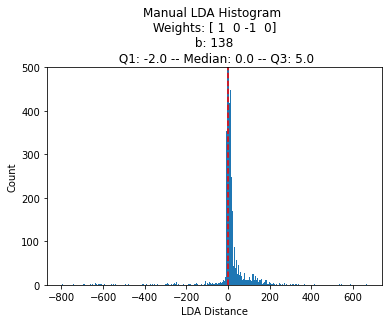

In [186]:
q1 = np.percentile(all_lda_distances, 25)
q2 = np.percentile(all_lda_distances, 50)
q3 = np.percentile(all_lda_distances, 75)
plt.hist(all_lda_distances, bins=1000)
plt.axvline(q2, color='red', linestyle='--')
plt.ylim(0, 500)
plt.xlabel('LDA Distance')
plt.ylabel('Count')
plt.title('Manual LDA Histogram \n Weights: {} \n b: {} \n Q1: {} -- Median: {} -- Q3: {}'.format(weights, b, q1, q2, q3))
plt.show()

### Aside:  find applicable range of b values
##### $x_1$ = 1 or 2 stds above mean value of feature channel during NO STIM
##### $y_1$ = mean value of stim channel during NO STIM
##### $x_2$ = mean value of feature channel during STIM
##### $y_2$ = mean value of stim channel during STIM
##### Find b such that the following inequalities are satisfied:
##### $\hspace{2cm} -[x_1w_x + y_1w_y - b] > 0$
##### (want detector to turn on when feature channel input is sufficiently high)
##### $\hspace{2cm} -[x_2w_x + y_2w_y - b] < 0$  
##### (want detector to turn off when stim is on)
##### where $w_x$ = LDA weight for the feature channel and $w_y$ = LDA weight for the stim channel


In [164]:
all_feature_ch_no_stim = [] # x1
all_feature_ch_stim = []    # x2
all_stim_ch_no_stim = []    # y1
all_stim_ch_stim = []       # y2

# No Stim
for fp in tqdm(cl_data_files):
    df = load_recording(fp,
                    filter_out_stim=True,
                    filter_in_stim=False,
                    verbose=False)
    all_stim_ch_no_stim.append(df['ch1'])
    all_feature_ch_no_stim.append(df['ch3'])
    
# Stim 
for fp in tqdm(cl_data_files):
    df = load_recording(fp,
                    filter_out_stim=False,
                    filter_in_stim=True,
                    verbose=False)
    all_stim_ch_stim.append(df['ch1'])
    all_feature_ch_stim.append(df['ch3'])

feature_ch_no_stim = pd.concat(all_feature_ch_no_stim)
feature_ch_stim = pd.concat(all_feature_ch_stim)
stim_ch_no_stim = pd.concat(all_stim_ch_no_stim)
stim_ch_stim = pd.concat(all_stim_ch_stim)

100%|██████████| 196/196 [00:00<00:00, 311.84it/s]


In [179]:
x1 = np.mean(feature_ch_no_stim) + np.std(feature_ch_no_stim)
x2 = np.mean(feature_ch_stim)
y1 = np.mean(stim_ch_no_stim)
y2 = np.mean(stim_ch_stim)
wx, wy = -1, 1

In [178]:
b_lb = x1*wx + y1*wy
b_ub = x2*wx + y2*wy
print('{} < b < {}'.format(np.round(b_lb, 2), np.round(b_ub, 2)))

94.01 < b < 482.91


### To-do: optimize onset and offset durations 